In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import nltk
from html.parser import HTMLParser

In [3]:
prof = pd.read_csv("../professionals.csv")
answ = pd.read_csv("../answers.csv")
stud = pd.read_csv("../students.csv")
ques = pd.read_csv("../questions.csv")
emai = pd.read_csv("../emails.csv")
matc = pd.read_csv("../matches.csv")
tagq = pd.read_csv("../tag_questions.csv")
taqu = pd.read_csv("../tag_users.csv")

Where professionals and students are from (locations and number). Which locations have both professionals and students. 

In [4]:
print(prof.professionals_location.value_counts().head(10))
print("\n")
print(stud.students_location.value_counts().head(10))

p_loc = np.array(prof['professionals_location'].values.tolist())
s_loc = np.array(stud['students_location'].values.tolist())

i = np.intersect1d(p_loc,s_loc)
print("\nThese are the locations with both professionals and students: {}".format(i))
print("\nIn total, there are {} locations with both professional and students".format(i.size))


New York, New York            1337
California, California         864
Greater New York City Area     745
Boston, Massachusetts          714
Los Angeles, California        617
Atlanta, Georgia               578
Chicago, Illinois              576
Austin, Texas                  574
Houston, Texas                 556
San Francisco Bay Area         513
Name: professionals_location, dtype: int64


New York, New York             1313
Bengaluru, Karnataka, India     890
Los Angeles, California         663
Hyderabad, Telangana, India     597
Boston, Massachusetts           557
San Francisco, California       550
San Jose, California            548
Houston, Texas                  476
Chennai, Tamil Nadu, India      437
Chicago, Illinois               344
Name: students_location, dtype: int64

These are the locations with both professionals and students: ['Abilene, Texas' 'Abu Dhabi, United Arab Emirates' 'Abuja, FCT, Nigeria'
 ... 'York, Pennsylvania' 'Ypsilanti, Michigan' 'nan']

In total, ther

[Text(0, 0, 'New York, New York'),
 Text(0, 0, 'California, California'),
 Text(0, 0, 'Greater New York City Area'),
 Text(0, 0, 'Boston, Massachusetts'),
 Text(0, 0, 'Los Angeles, California'),
 Text(0, 0, 'Atlanta, Georgia'),
 Text(0, 0, 'Chicago, Illinois'),
 Text(0, 0, 'Austin, Texas'),
 Text(0, 0, 'Houston, Texas'),
 Text(0, 0, 'San Francisco Bay Area'),
 Text(0, 0, 'San Francisco, California'),
 Text(0, 0, 'Philadelphia, Pennsylvania'),
 Text(0, 0, 'Bengaluru, Karnataka, India'),
 Text(0, 0, 'Greater Atlanta Area'),
 Text(0, 0, 'Dallas/Fort Worth Area'),
 Text(0, 0, 'Greater Los Angeles Area'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Greater Chicago Area'),
 Text(0, 0, 'Houston, Texas Area'),
 Text(0, 0, 'Greater Boston Area')]

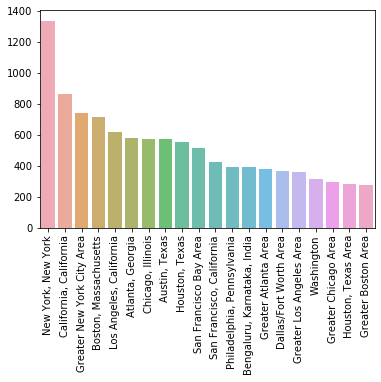

In [23]:
## Let's plot this in bar graph form
location_count = prof['professionals_location'].value_counts()
location_count = location_count[:20,]

g = sns.barplot(location_count.index, location_count.values, alpha=0.8)
g.set_xticklabels(location_count.index, rotation=90)

[Text(0, 0, 'New York, New York'),
 Text(0, 0, 'Bengaluru, Karnataka, India'),
 Text(0, 0, 'Los Angeles, California'),
 Text(0, 0, 'Hyderabad, Telangana, India'),
 Text(0, 0, 'Boston, Massachusetts'),
 Text(0, 0, 'San Francisco, California'),
 Text(0, 0, 'San Jose, California'),
 Text(0, 0, 'Houston, Texas'),
 Text(0, 0, 'Chennai, Tamil Nadu, India'),
 Text(0, 0, 'Chicago, Illinois'),
 Text(0, 0, 'Oakland, California'),
 Text(0, 0, 'San Antonio, Texas'),
 Text(0, 0, 'Dallas, Texas'),
 Text(0, 0, 'Owensboro, Kentucky'),
 Text(0, 0, 'Providence, Rhode Island'),
 Text(0, 0, 'Lakeland, Florida'),
 Text(0, 0, 'Pittsburgh, Pennsylvania'),
 Text(0, 0, 'Irving, Texas'),
 Text(0, 0, 'Miami, Florida'),
 Text(0, 0, 'Atlanta, Georgia')]

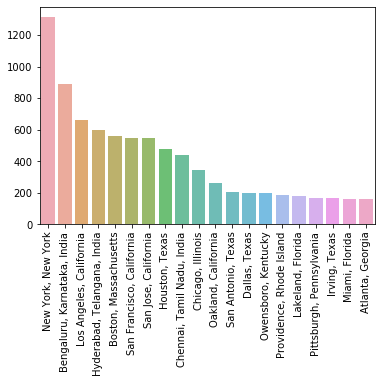

In [22]:
location_count2 = stud['students_location'].value_counts()
location_count2 = location_count2[:20,]
f = sns.barplot(location_count2.index, location_count2.values, alpha=0.8)
f.set_xticklabels(location_count2.index, rotation=90)

Which industries are most of these professionals in?

In [6]:
prof.professionals_industry.value_counts().head(10)

Telecommunications                     3166
Information Technology and Services    2109
Computer Software                      1272
Hospital and Health Care                862
Higher Education                        800
Accounting                              781
Financial Services                      639
Education Management                    593
Marketing and Advertising               526
Internet                                427
Name: professionals_industry, dtype: int64

[Text(0, 0, 'Telecommunications'),
 Text(0, 0, 'Information Technology and Services'),
 Text(0, 0, 'Computer Software'),
 Text(0, 0, 'Hospital and Health Care'),
 Text(0, 0, 'Higher Education'),
 Text(0, 0, 'Accounting'),
 Text(0, 0, 'Financial Services'),
 Text(0, 0, 'Education Management'),
 Text(0, 0, 'Marketing and Advertising'),
 Text(0, 0, 'Internet'),
 Text(0, 0, 'Human Resources'),
 Text(0, 0, 'Mechanical or Industrial Engineering'),
 Text(0, 0, 'Management Consulting'),
 Text(0, 0, 'Research'),
 Text(0, 0, 'Non-profit Organization Management'),
 Text(0, 0, 'Law Practice'),
 Text(0, 0, 'Entertainment'),
 Text(0, 0, 'Health, Wellness and Fitness'),
 Text(0, 0, 'Medical Practice'),
 Text(0, 0, 'Computer Hardware')]

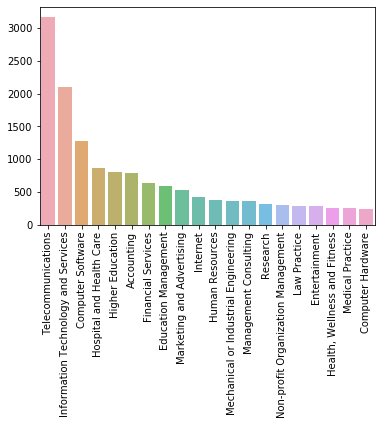

In [19]:
## Let's plot this as a barp graph
industry_count = prof['professionals_industry'].value_counts()
industry_count = industry_count[:20,]

g = sns.barplot(industry_count.index, industry_count.values, alpha=0.8)
g.set_xticklabels(industry_count.index, rotation=90)

What are key words (NN) from students' questions? First strip html tags from answers and questions and access the nouns using nltk.tag_pos() and nltk.word_tokenizer()

Here we can then plot all the different NN* to see what words are "big" in students' questions. 

In [8]:
## This class strips all HTML encoding in the responses 
## It takes in a string and returns an HTML-free string
## Usage: strip_tags(df.text_body.iloc[i]) for i in range(0:df.size)

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)
    
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [20]:
words = {}
a = (answ.answers_body.iloc[1])
a = strip_tags(a)


### tokenize the answers and then classify parts of speech. Keep words that are NN
### Make a dictionary to update the frequency of these individual words across all words. 
b = (nltk.pos_tag(nltk.word_tokenize(a)))

for i in b: 
    if (i[1] == "NN" or i[1] == "NNP" or i[1] == "NNS" or i[1] == "NNPS"):
        current = i[0].lower()
        if current in words.keys(): 
            words[current] += 1
        else:
            words[current] = 0

for k,v in words.items():
    print(k,v)

hi 0
army 0
college 1
bachelor 0
degree 3
criminal 0
justice 0
officers 0
military 2
year 0
officer 2
training 1
tour 0
reserve 0
corps 0
rotc 0
school 1
university 0
candidate 0
ocs 0
become 0
experience 0
success 0
future 0
